<a href="https://colab.research.google.com/github/jimuelceleste/system-modeling-notes/blob/main/EnE%20305%20-%20Sensitivity_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ASQ-SEIR-NLIR 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

def get_asq_seir_nlir(params):
    beta = params["beta"]
    sigma = params["sigma"]
    gamma = params["gamma"]
    q = params["q"]
    u = params["u"]
    alpha = params["alpha"]
    epsilon = params["epsilon"]
  
    def asq_seir_nlir(t, y):
        s,e,i,r = y
        n = sum(y)
        return np.array([
            (-beta * q * s * i / n) / ((1 + alpha * s / n) * (1 + epsilon * i / n)), 
            ((beta * q * s * i / n) / ((1 + alpha * s / n) * (1 + epsilon * i / n))) - sigma * u * e, 
            sigma * u * e - gamma * i, 
            gamma * i
        ])
    return asq_seir_nlir

In [ ]:
# Runge-Kutta 4th Order Method
def rk4(f, h, t0, y0):
    k1 = f(t0, y0)
    k2 = f(t0 + h/2, y0 + h * k1/2)
    k3 = f(t0 + h/2, y0 + h * k2/2)
    k4 = f(t0 + h, y0 + h * k3)
    return y0 + 1/6 * h * (k1 + 2*k2 + 2*k3 + k4)

In [ ]:
# Philippine Population as of May 1, 2020 https://psa.gov.ph/population-and-housing/node/166426 
ph_pop = 109035343

# Fully Vaccinated as of March 30, 2022 https://doh.gov.ph/covid19-vaccination-dashboard
fully_vaccinated = 65885048
estimated_efficacy = 0.77 # Computations of Nico and Thomas as of January 2022

# COVID cases as of April 2, 2022: https://doh.gov.ph/covid19tracker
e0 = 0 # assumption
i0 = 37115
r0 = 3582529 + 59324 + (fully_vaccinated * estimated_efficacy) # recovered + dead + estimated immune 
s0 = ph_pop - (e0 + i0 + r0)
y0 = np.array([s0, e0, i0, r0]) / ph_pop
print(y0)

[5.00983319e-01 0.00000000e+00 3.40394215e-04 4.98676287e-01]


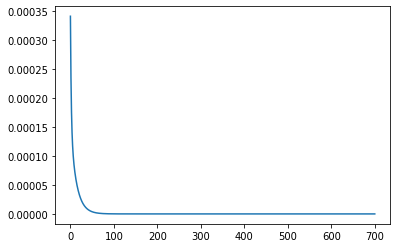

In [ ]:
# Sample Simulation
f = get_asq_seir_nlir({
    "beta": 2,
    "sigma": 0.28,
    "gamma": 0.33, 
    "q": 0.2,
    "u": 1,
    "alpha": 0.13,
    "epsilon": 0.7
})

seir = [y0]
time = [0]
dt = 0.25
t = dt
tn = 700
y = y0

while t <= tn: 
    y = rk4(f, dt, t, y)
    seir.append(y)
    time.append(t)
    t += dt 

seir = pd.DataFrame(seir, columns=["S", "E", "I", "R"])
plt.plot(time, seir["I"])

In [ ]:
import random 
from copy import deepcopy

# Elementary Effect
def elem_effect(y1, y2, delta):
    return (y2 - y1) / delta

# Number of new infectives 
def count_new_infectives(s):
    return s[0] - s[-1]

# Duration of the spread
def get_spread_duration(i):
    duration = len(i)
    for index, element in enumerate(i): 
      if element <= 0.000001 and duration == len(i):
        duration = index
    return duration 

# IVP Solver 
def solve_ivp(h, tn, y0, t0, f, solver):
    """ 
      h - time step 
      tn - maximum time 
      y0 - initial value 
      t0 - initial time 
      f - ODE to solve 
      solver - solver of choice
    """
    time = [0]
    seir = [y0]
    t = t0 + h
    y = y0 

    while t <= tn:
        y = solver(f, h, t, y)
        time.append(t)
        seir.append(y)
        t += h
    
    return pd.DataFrame(seir, columns=["S","E","I","R"]), time

In [ ]:
# Levels of the paramater space
p = 10

# Parameter Step Size
delta = 1 / (p - 1)

# Parameter Ranges 
ranges = {
    "beta": [2, 3.5 - delta],
    "sigma": [0.1, 0.14 - delta],
    "gamma": [0.2, 0.33 - delta], 
    "q": [0, 1 - delta],
    "u": [0, 1 - delta],
    "alpha": [0, 1 - delta],
    "epsilon": [0, 1 - delta]
}

x = np.arange(0, 1, delta)
r = 5 # iterations

# Parameters for PH as estimated by Santos, Gabriel Lorenzo (2022)
param0 = {
    "beta": 2,
    "sigma": 0.28,
    "gamma": 0.33, 
    "q": 0.2,
    "u": 1,
    "alpha": 0.13,
    "epsilon": 0.7
}

new_infectives = {
    "beta": [],
    "sigma": [],
    "gamma": [], 
    "q": [],
    "u": [],
    "alpha": [],
    "epsilon": []
}

durations = deepcopy(new_infectives)

for param in ["beta", "sigma", "gamma", "q", "u", "alpha", "epsilon"]:
    params = deepcopy(param0)

    for new_param in x:
        params[param] = new_param
        f = get_asq_seir_nlir(params)
        seir1, _ = solve_ivp(0.25, 1500, y0, 0, f, rk4)
        new1 = count_new_infectives(seir1["S"].values)
        dur1 = get_spread_duration(seir1["I"].values)
        
        params[param] += delta
        f = get_asq_seir_nlir(params)
        seir2, _ = solve_ivp(0.25, 1500, y0, 0, f, rk4)
        seir = pd.DataFrame(seir2, columns=["S", "E", "I", "R"])
        # plt.plot(seir["I"])
        # print(seir["I"].tail())
        # break
        new2 = count_new_infectives(seir2["S"].values)
        dur2 = get_spread_duration(seir2["I"].values )

        new_infectives[param].append( elem_effect(new1, new2, delta) )
        durations[param].append( elem_effect(dur1, dur2, delta) )

        print(dur1, dur2, new1, new2)

print(new_infectives)
print(durations)

71 79 0.0 1.1132641135280785e-05
79 86 1.1132641135280785e-05 2.3017868717944978e-05
86 94 2.3017868717944978e-05 3.573463598016691e-05
94 101 3.573463598016691e-05 4.937333544519085e-05
101 109 4.937333544519085e-05 6.403794758425008e-05
109 116 6.403794758425008e-05 7.984869240484915e-05
116 124 7.984869240484915e-05 9.694532687598567e-05
124 133 9.694532687598567e-05 0.00011549127928767167
133 142 0.00011549127928767167 0.00013567887925336475
71 430 0.00019400774010203126 0.0004509291699036355
430 300 0.0004509291699036355 0.0004509184653374021
300 253 0.0004509184653374021 0.00045091134738206584
253 230 0.00045091134738206584 0.00045090627213728585
230 216 0.00045090627213728585 0.00045090247062662403
216 207 0.00045090247062662403 0.00045089951681032137
207 201 0.00045089951681032137 0.000450897155594987
201 196 0.000450897155594987 0.0004508952249052678
196 192 0.0004508952249052678 0.00045089361683259277
6001 1677 0.5009833191426747 0.3487399038450449
1677 1046 0.348739903845044

beta 0.00013567887925336475 2.620908141975377e-05
sigma 0.000256956982872647 0.0007266961113097859
gamma 0.5009044533367876 1.0201300515657183
q 0.4669904597668126 0.5685625441896456
u 0.0002569597307484628 0.0007267262505503014
alpha 0.0002943086165623221 0.00014178367371051634
epsilon 1.2329413534573064e-07 2.374512326766903e-11


Text(0.5, 1.0, 'Number of New Infectives')

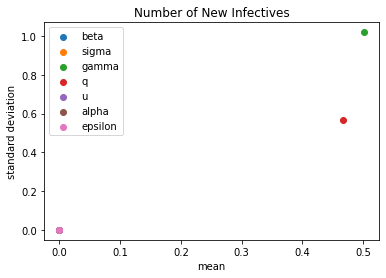

In [ ]:
for param in ["beta", "sigma", "gamma", "q", "u", "alpha", "epsilon"]:
    mu = np.mean(np.abs(new_infectives[param])) #* 100
    std = np.std(new_infectives[param]) #* 100
    print(param, mu, std)
    plt.scatter(mu, std, label=param)
  
plt.legend()
plt.xlabel("mean")
plt.ylabel("standard deviation") 
plt.title("Number of New Infectives")
# high standard deviation => nonlinear relationship
# high mean => influential
# gamma = removal rate 
# q = quarantine
# all else, small mean and standard deviations

beta 71.0 6.6332495807108
sigma 597.0 1151.1802639030952
gamma 5939.0 11924.14785215279
q 3999.0 6510.700115962953
u 1506.0 2767.0988417474355
alpha 119.0 55.60575509783138
epsilon 0.0 0.0


Text(0.5, 1.0, 'Duration of the Disease-spread')

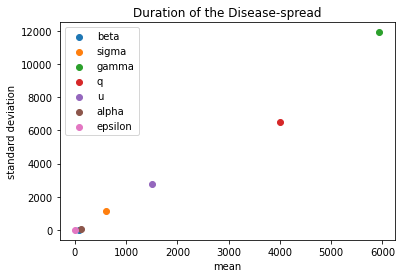

In [ ]:
for param in ["beta", "sigma", "gamma", "q", "u", "alpha", "epsilon"]:
    mu = np.mean(np.abs(durations[param])) #* 100
    std = np.std(durations[param]) #* 100
    print(param, mu, std)
    plt.scatter(mu, std, label=param)
    # plt.annotate(param, (mu, std))

plt.legend()
plt.xlabel("mean")
plt.ylabel("standard deviation") 
plt.title("Duration of the Disease-spread")
# high standard deviation => nonlinear relationship
# high mean => influential
# gamma = removal rate 
# q = quarantine
# all else, small mean and standard deviations